In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms
import torch
from tqdm import tqdm
import time
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [6]:
pt_19th = pd.read_csv('../DATA/pt_19th.csv')
dr_19th = pd.read_csv('../DATA/dr_19th.csv')

In [7]:
pt_19th.head()

,Year,URL,isPublic,Type,Era
0,1808,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1800s
1,1800,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1800s
2,1802,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1800s
3,1801,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1800s
4,1800,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1800s


In [8]:
'''
Function Purpose: Given a URL and desired future image size will:
1. Fetch the corresponding image at URL
2. Upon fetching the image will standardize it preserving aspect ratio then return the image

Code developed with help of Chat GPT. We used 244 x 244 as an initial size due to online literature that suggests pre-trained model work best for images with these resolutions
'''
def fetch_and_standardize_image(url, size=(224, 224)):

    #1. First attempt to ping the url and get the associated image
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()

        #2. Once you have the response use it to grab the image and for consistency make sure it is RGB every time, for testing I have added a print statement here to see original image
        img = Image.open(BytesIO(response.content)).convert("RGB")
       #plt.imshow(img)
        #plt.axis('off')  # Turn off axis labels
        #plt.title("Image before Resizing")
        #plt.show()


        #3. Get the original dimensions of the artwork to guide resizing step
        orig_width, orig_height = img.size

        #4. This part of the code looks at the original dimensions and the desired dimensions to work to resize the image while maintaining aspect ratio
        if orig_width > orig_height:
            new_width = size[0]
            new_height = int(size[1] * orig_height / orig_width)
        else:
            new_height = size[1]
            new_width = int(size[0] * orig_width / orig_height)

        #5. Resize the image now to the newly calculated dimensions
        img_resized = img.resize((new_width, new_height), Image.BICUBIC)

        #6. Pad the image to match the desired size (adds padding where necissary to ensure the image fits within the target size specified in function parameters)
        img_padded = ImageOps.pad(img_resized, size, color=(255, 255, 255))

        #7. Showcases the image that has been resized, this is before the next step which will then convert the image into a numeric format for use in nueral net
        #plt.imshow(img_padded)
        #plt.axis('off')  # Turn off axis labels
        #plt.title("Image After Resizing")
        #plt.show()

        ''''
        #7. Prepares the image data to be used in a nueral network, changing an image into numbers so the returned image can be used in the machine learning model
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        '''

        #return transform(img_padded)
        img_array = img_to_array(img_padded)
        return img_array

    #Additional error handling as needed
    except Exception as e:
        print(f"Error fetching or processing image: {e}")
        return None

In [9]:
#Test invocation of the fetch and standardize image function
print(pt_19th.iloc[1].URL)
test_url = pt_19th.iloc[1].URL
test_image = fetch_and_standardize_image(test_url)
print("Function returns the tensor image : ", test_image)

https://images.metmuseum.org/CRDImages/ep/original/DP-14274-013.jpg
Function returns the tensor image :  [[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


In [10]:
#1. Added a binary encoding where paintings are 0 and drawings are 1 in a label column so when merged have a easy variable to reference for model
pt_19th['label'] = 0  # Paintings
dr_19th['label'] = 1  # Drawings

#2. Combine the painting and drawing dataframes so we have one dataframe. Sample function used to randomize order of joined dataframe
all_data = pd.concat([pt_19th, dr_19th]).sample(frac=1).reset_index(drop=True)

#3. Testing to see new resulting dataframe, because randomization with sample can see both paintings and drawings at top
all_data.head()

,Year,URL,isPublic,Type,Era,label
0,1840,https://images.metmuseum.org/CRDImages/dp/orig...,True,drawing,1840s,1
1,1895,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1890s,0
2,1814,https://images.metmuseum.org/CRDImages/dp/orig...,True,drawing,1810s,1
3,1880,https://images.metmuseum.org/CRDImages/ep/orig...,True,painting,1880s,0
4,1882,https://images.metmuseum.org/CRDImages/dp/orig...,True,drawing,1880s,1


In [11]:
#1. Create an empty array to store the tensor format of each image in the all data dataframe
tensor_images = []

#2. Incremenet through each row and for each row using the url present call the fetch image function to get its numerical and lower res image
for i, row in all_data.iterrows():
    print(f"Processing row {i}")
    time.sleep(0.1)
    img_tensor = fetch_and_standardize_image(row['URL'], size=(224, 224))
    tensor_images.append(img_tensor)

# 3. Using the populated tensor_images array now store results in the dataframe
all_data['tensor_image'] = tensor_images

#4. Remove any images that are null / had errors and print dataframe out to see if it worked
final_data = all_data[all_data['tensor_image'].notnull()].reset_index(drop=True)
final_data.head()

#5. Save to a csv called final data, left commented out because once it is run once we do not need to resave
final_data.to_csv('../DATA/final_joined_data.csv', index=False)

Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processing row 53
Processing row 54
Processing row 55
Pr

In [12]:
#Need to now get an arrays for the two things needed in the model (an array of the tensor photos, and then an array of the binary labels)

#1. Getting an array of the tensor images (according to chat .stack is needed to enforce the shape here). Probably because nested array structure the underlying shape could be different but given checks shouldnt be an issue.
X = np.stack(final_data['tensor_image'].values)

#2. Getting an Array of the binary labels, num classes for 0 and 1
y = to_categorical(final_data['label'].values, num_classes=2)


In [13]:
#We have the two arrays needed to run the model on, now create the train test split using standard .2 test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
#1. Load ResNet50 model, includes the input shape that we standardized the images to be in and gets head start from imagenet trained by microsoft
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#2. According to Chat need to preserve original weights of the model while adding ontop of it but not changing foundational aspects
for layer in base_model.layers:
    layer.trainable = False

#3. Adding the specific painting or drawing classification
# Chat helped and https://forums.fast.ai/t/finetuning-top-layers-of-cnn-using-keras/18013/3, details abstracted away
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

#4. Building the model
model = Model(inputs=base_model.input, outputs=predictions)

#5. Model is compiled for actual use
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#1. Now that model has been created need to fit it with train and test data, epochs are the amount of rounds the model goes through the test data
#Earlier Epochs are less likely to be accurate because weightings have not been established but after each round (epoch) it trys to update it based on performance
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)

#2. Evaluate the accurage of the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.6088 - loss: 0.6621 - val_accuracy: 0.9198 - val_loss: 0.2652
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9005 - loss: 0.2521 - val_accuracy: 0.9444 - val_loss: 0.1725
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9234 - loss: 0.1921 - val_accuracy: 0.9691 - val_loss: 0.1385
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9622 - loss: 0.1458
Test Accuracy: 0.97


Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9682 - loss: 0.1288 - val_accuracy: 0.9691 - val_loss: 0.1223
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9697 - loss: 0.1147 - val_accuracy: 0.9753 - val_loss: 0.1141
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9770 - loss: 0.0852 - val_accuracy: 0.9691 - val_loss: 0.1063


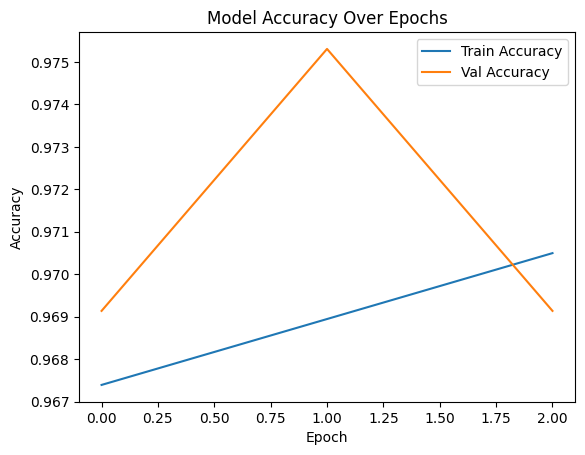

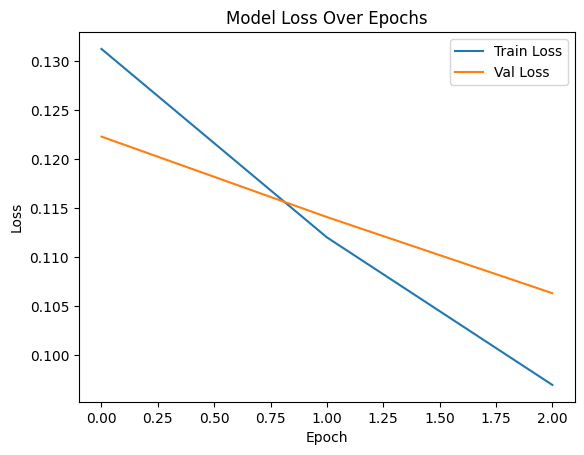

In [16]:
#final accuracy & loss over epochs
#Plots made: Training vs Validation accuracy and Training vs Validation loss to show if the model overfits or learns effectively
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)


# Assume `history` is your model's fit history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


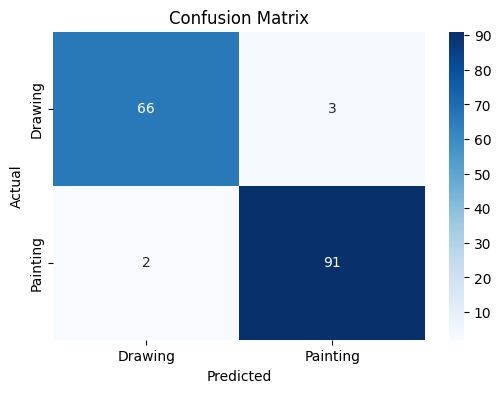

              precision    recall  f1-score   support

     Drawing       0.97      0.96      0.96        69
    Painting       0.97      0.98      0.97        93

    accuracy                           0.97       162
   macro avg       0.97      0.97      0.97       162
weighted avg       0.97      0.97      0.97       162



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#confusion matrixes

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Drawing','Painting'], yticklabels=['Drawing','Painting'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Drawing', 'Painting']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

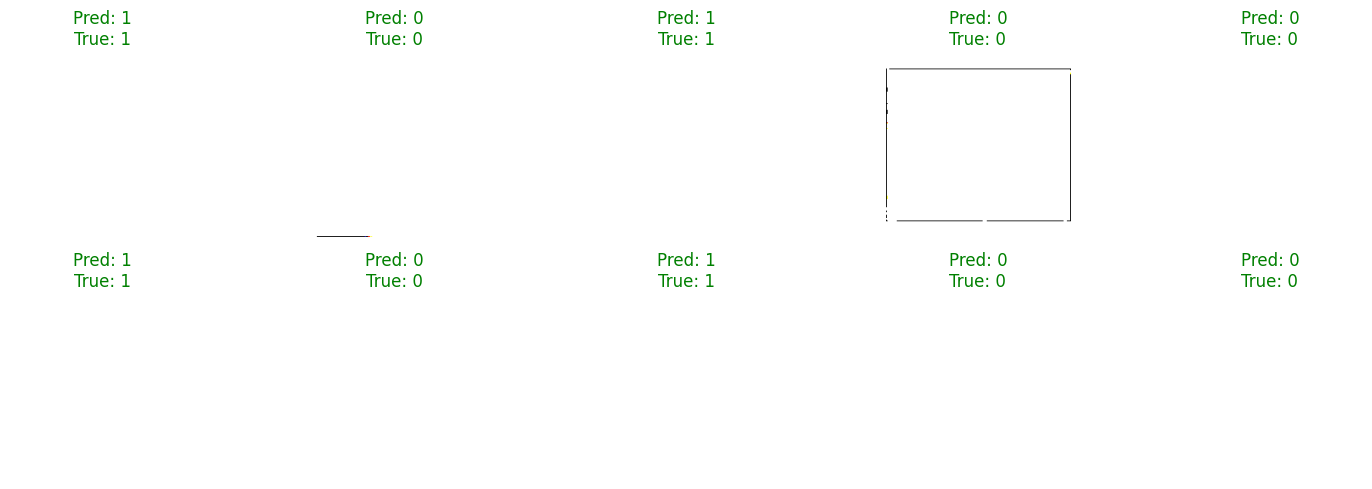

In [18]:
#example predictions

# Select a few test images
num_images = 10
indices = np.random.choice(len(X_test), num_images, replace=False)
images = X_test[indices]
true_labels = np.argmax(y_test[indices], axis=1)
pred_labels = np.argmax(model.predict(images), axis=1)

# Plot images
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    color = 'green' if pred_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {pred_labels[i]}\nTrue: {true_labels[i]}", color=color)
plt.tight_layout()
plt.show()


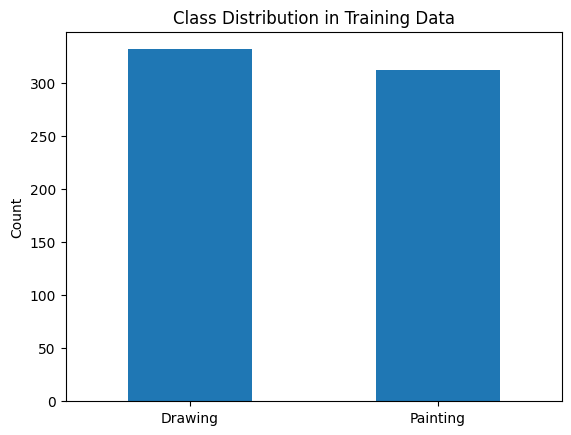

In [19]:
#class distribution in datasets
class_counts = pd.Series(np.argmax(y_train, axis=1)).value_counts()
class_counts.plot(kind='bar', title='Class Distribution in Training Data')
plt.xticks([0, 1], ['Drawing', 'Painting'], rotation=0)
plt.ylabel('Count')
plt.show()

#shows that there's more drawings than paintings but this isn't necessarily enough to skew the data significantly

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step


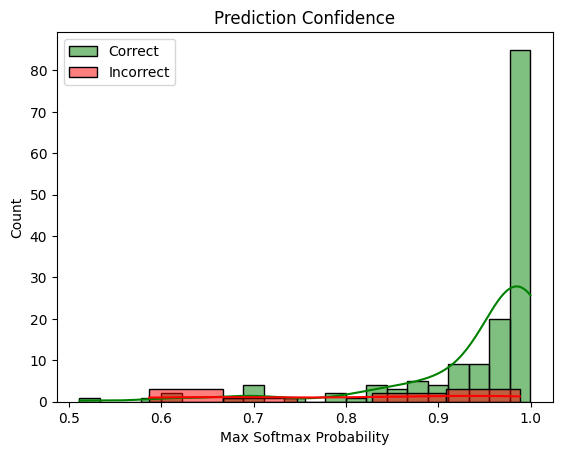

In [ ]:
#Model confidence/Softmax Scores

probs = model.predict(X_test)
confidences = np.max(probs, axis=1)
correct = (np.argmax(probs, axis=1) == np.argmax(y_test, axis=1))

sns.histplot(confidences[correct], color='green', label='Correct', kde=True)
sns.histplot(confidences[~correct], color='red', label='Incorrect', kde=True)
plt.title('Prediction Confidence')
plt.xlabel('Max Softmax Probability')
plt.legend()
plt.show()



In [20]:
#summary tables of key metrics
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), target_names=['Drawing', 'Painting']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
              precision    recall  f1-score   support

     Drawing       0.97      0.96      0.96        69
    Painting       0.97      0.98      0.97        93

    accuracy                           0.97       162
   macro avg       0.97      0.97      0.97       162
weighted avg       0.97      0.97      0.97       162

